# Cleaning and EDA

This notebook focuses on cleaning up the dataset a little bit and then exploring the data. As with all posts to Reddit, there may be some unsavory language, so I appologize for that in advance. 


The goal here is to determine what words in a post will allow us to best predict whether a post came from r/science or r/todayilearned. Both subreddits can be considered education based in a way, with r/science focused on science news while r/todayilearned is about fun facts that people stumble upon.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import re

pd.options.display.max_colwidth = 400

## Clean and Prep the Data

First I will replace every "\[removed\]" and NaN with a blank string. That way I can still use the other details from the post while keeping "\[removed\]" from throwing off the models. I am then going to merge the title and selftext columns into one column simply called all_text.

In [2]:
df = pd.read_csv('../data/raw/posts.csv')
df.head()

,title,selftext,subreddit,created_utc
0,Germany Aims To Get 100% of Energy From Renewable Sources By 2035,NaN,science,1646141490
1,Ambiental Dedetização - Dedetizadora e controle de Pragas,NaN,science,1646140604
2,"Alcohol use by parents of young children was related to how many bars and restaurants were near where they shopped, where they worked and where their children went to school, a new study finds.",NaN,science,1646138910
3,Neighbourhoods Play A Role In Health Of Adults. Results confirm previous findings but now also show a clear link between living environments and physical and mental health. He believes they should help inform city planning policy and decision-making.,NaN,science,1646132676
4,Ultrasound scan can diagnose prostate cancer. The ultrasound scans missed only 4.3 per cent more clinically important prostate cancer cases – cancer that should be treated rather than monitored – compared to magnetic resonance imaging (MRI) scans currently used to detect prostate cancer,NaN,science,1646132446


In [3]:
df.isnull().sum()

title             0
selftext       2971
subreddit         0
created_utc       0
dtype: int64

In [4]:
df[df['selftext'].isnull()]

,title,selftext,subreddit,created_utc
0,Germany Aims To Get 100% of Energy From Renewable Sources By 2035,NaN,science,1646141490
1,Ambiental Dedetização - Dedetizadora e controle de Pragas,NaN,science,1646140604
2,"Alcohol use by parents of young children was related to how many bars and restaurants were near where they shopped, where they worked and where their children went to school, a new study finds.",NaN,science,1646138910
3,Neighbourhoods Play A Role In Health Of Adults. Results confirm previous findings but now also show a clear link between living environments and physical and mental health. He believes they should help inform city planning policy and decision-making.,NaN,science,1646132676
4,Ultrasound scan can diagnose prostate cancer. The ultrasound scans missed only 4.3 per cent more clinically important prostate cancer cases – cancer that should be treated rather than monitored – compared to magnetic resonance imaging (MRI) scans currently used to detect prostate cancer,NaN,science,1646132446
...,...,...,...,...
2992,TIL Pandora didn't have a box,NaN,todayilearned,1645530046
2993,Ms Excel Complete course for beginners to Advance level|| step by step|| Part 2,NaN,todayilearned,1645529820
2994,"TIL If measured from the ocean floor, Mount Teide at it's height of 7500 m is the third-highest volcano in the world.",NaN,todayilearned,1645529785
2995,Nehmen Sie an einem Supermarkt-Gutschein teil! kostenlos,NaN,todayilearned,1645528261


In [5]:
df.fillna('', inplace=True)

In [6]:
def clean_removed(text):
    if text == '[removed]':
        return ''
    return text

In [7]:
df['selftext'] = df['selftext'].map(clean_removed)

In [8]:
df.head()

,title,selftext,subreddit,created_utc
0,Germany Aims To Get 100% of Energy From Renewable Sources By 2035,,science,1646141490
1,Ambiental Dedetização - Dedetizadora e controle de Pragas,,science,1646140604
2,"Alcohol use by parents of young children was related to how many bars and restaurants were near where they shopped, where they worked and where their children went to school, a new study finds.",,science,1646138910
3,Neighbourhoods Play A Role In Health Of Adults. Results confirm previous findings but now also show a clear link between living environments and physical and mental health. He believes they should help inform city planning policy and decision-making.,,science,1646132676
4,Ultrasound scan can diagnose prostate cancer. The ultrasound scans missed only 4.3 per cent more clinically important prostate cancer cases – cancer that should be treated rather than monitored – compared to magnetic resonance imaging (MRI) scans currently used to detect prostate cancer,,science,1646132446


In [9]:
df['all_text'] = df['title'] + df['selftext']

In [10]:
df

,title,selftext,subreddit,created_utc,all_text
0,Germany Aims To Get 100% of Energy From Renewable Sources By 2035,,science,1646141490,Germany Aims To Get 100% of Energy From Renewable Sources By 2035
1,Ambiental Dedetização - Dedetizadora e controle de Pragas,,science,1646140604,Ambiental Dedetização - Dedetizadora e controle de Pragas
2,"Alcohol use by parents of young children was related to how many bars and restaurants were near where they shopped, where they worked and where their children went to school, a new study finds.",,science,1646138910,"Alcohol use by parents of young children was related to how many bars and restaurants were near where they shopped, where they worked and where their children went to school, a new study finds."
3,Neighbourhoods Play A Role In Health Of Adults. Results confirm previous findings but now also show a clear link between living environments and physical and mental health. He believes they should help inform city planning policy and decision-making.,,science,1646132676,Neighbourhoods Play A Role In Health Of Adults. Results confirm previous findings but now also show a clear link between living environments and physical and mental health. He believes they should help inform city planning policy and decision-making.
4,Ultrasound scan can diagnose prostate cancer. The ultrasound scans missed only 4.3 per cent more clinically important prostate cancer cases – cancer that should be treated rather than monitored – compared to magnetic resonance imaging (MRI) scans currently used to detect prostate cancer,,science,1646132446,Ultrasound scan can diagnose prostate cancer. The ultrasound scans missed only 4.3 per cent more clinically important prostate cancer cases – cancer that should be treated rather than monitored – compared to magnetic resonance imaging (MRI) scans currently used to detect prostate cancer
...,...,...,...,...,...
2992,TIL Pandora didn't have a box,,todayilearned,1645530046,TIL Pandora didn't have a box
2993,Ms Excel Complete course for beginners to Advance level|| step by step|| Part 2,,todayilearned,1645529820,Ms Excel Complete course for beginners to Advance level|| step by step|| Part 2
2994,"TIL If measured from the ocean floor, Mount Teide at it's height of 7500 m is the third-highest volcano in the world.",,todayilearned,1645529785,"TIL If measured from the ocean floor, Mount Teide at it's height of 7500 m is the third-highest volcano in the world."
2995,Nehmen Sie an einem Supermarkt-Gutschein teil! kostenlos,,todayilearned,1645528261,Nehmen Sie an einem Supermarkt-Gutschein teil! kostenlos


In [11]:
df['all_text'][0]

'Germany Aims To Get 100% of Energy From Renewable Sources By 2035'

In [12]:
df['all_text'][2996]

'TIL about 1st century Macedonian olympic winner Apollodorus, who was killed by lightening on his way home.'

Now that I have created the all text column, I am going to set science as the positive and todayilearned as the negative. I decided this by simply going in alphabetical order.

In [13]:
df['subreddit'] = df['subreddit'].map({'todayilearned': 0, 'science': 1})

In [14]:
df

,title,selftext,subreddit,created_utc,all_text
0,Germany Aims To Get 100% of Energy From Renewable Sources By 2035,,1,1646141490,Germany Aims To Get 100% of Energy From Renewable Sources By 2035
1,Ambiental Dedetização - Dedetizadora e controle de Pragas,,1,1646140604,Ambiental Dedetização - Dedetizadora e controle de Pragas
2,"Alcohol use by parents of young children was related to how many bars and restaurants were near where they shopped, where they worked and where their children went to school, a new study finds.",,1,1646138910,"Alcohol use by parents of young children was related to how many bars and restaurants were near where they shopped, where they worked and where their children went to school, a new study finds."
3,Neighbourhoods Play A Role In Health Of Adults. Results confirm previous findings but now also show a clear link between living environments and physical and mental health. He believes they should help inform city planning policy and decision-making.,,1,1646132676,Neighbourhoods Play A Role In Health Of Adults. Results confirm previous findings but now also show a clear link between living environments and physical and mental health. He believes they should help inform city planning policy and decision-making.
4,Ultrasound scan can diagnose prostate cancer. The ultrasound scans missed only 4.3 per cent more clinically important prostate cancer cases – cancer that should be treated rather than monitored – compared to magnetic resonance imaging (MRI) scans currently used to detect prostate cancer,,1,1646132446,Ultrasound scan can diagnose prostate cancer. The ultrasound scans missed only 4.3 per cent more clinically important prostate cancer cases – cancer that should be treated rather than monitored – compared to magnetic resonance imaging (MRI) scans currently used to detect prostate cancer
...,...,...,...,...,...
2992,TIL Pandora didn't have a box,,0,1645530046,TIL Pandora didn't have a box
2993,Ms Excel Complete course for beginners to Advance level|| step by step|| Part 2,,0,1645529820,Ms Excel Complete course for beginners to Advance level|| step by step|| Part 2
2994,"TIL If measured from the ocean floor, Mount Teide at it's height of 7500 m is the third-highest volcano in the world.",,0,1645529785,"TIL If measured from the ocean floor, Mount Teide at it's height of 7500 m is the third-highest volcano in the world."
2995,Nehmen Sie an einem Supermarkt-Gutschein teil! kostenlos,,0,1645528261,Nehmen Sie an einem Supermarkt-Gutschein teil! kostenlos


In [15]:
df.to_csv('../data/cleaned/prepped_posts.csv', index=False)
# Saving to csv to import over to modeling

## CountVectorizer (As Is)

In this section, I am going to run the data through CountVectorizer as is with no modificiations to see what we find. I will be using 'random_state=42' for my train_test_split here in the EDA notebook as well as in the modeling notebook to keep things consistant.

In [16]:
X = df['all_text']
y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, 
                                                    random_state=42)

In [17]:
cvec1 = CountVectorizer()
cvec1.fit(X_train)

X_train_cvec1 = cvec1.transform(X_train)
X_test_cvec1 = cvec1.transform(X_test)

In [18]:
X_train_cvec1.shape

(2247, 9716)

In [19]:
cvec1_train_df = pd.DataFrame(X_train_cvec1.todense(), columns = cvec1.get_feature_names())

cvec1_train_df['subreddit'] = y_train.values

cvec1_train_df.head()

,000,001,02,021,03938,073,0900,096,098,0ver,...,मत,यद,रभ,वध,सक,ひきこもり,𝐋𝐞𝐚𝐤𝐞𝐝,𝐓𝐞𝐞𝐧𝐬,𝟏𝟕,subreddit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


The following code for the graphs were taken from the lesson-nlp-ii starter-code. They will show the most common words used in r/todayilearned and r/science respectively

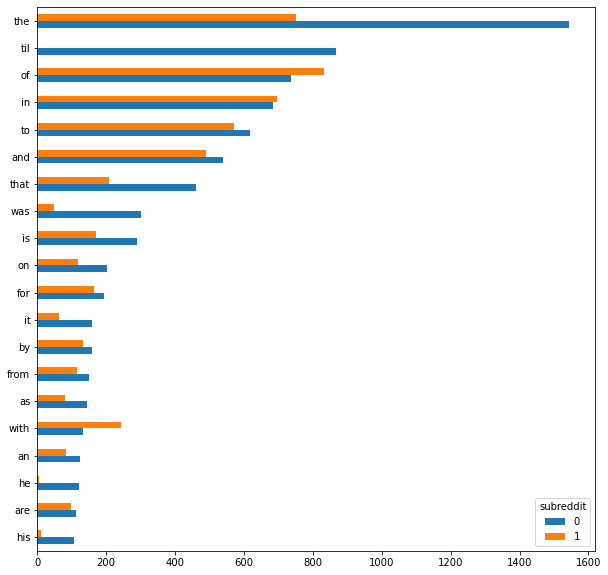

In [20]:
cvec1_train_df.groupby('subreddit').sum().T.sort_values(0, ascending=True).tail(20).plot.barh(figsize=(10,10));

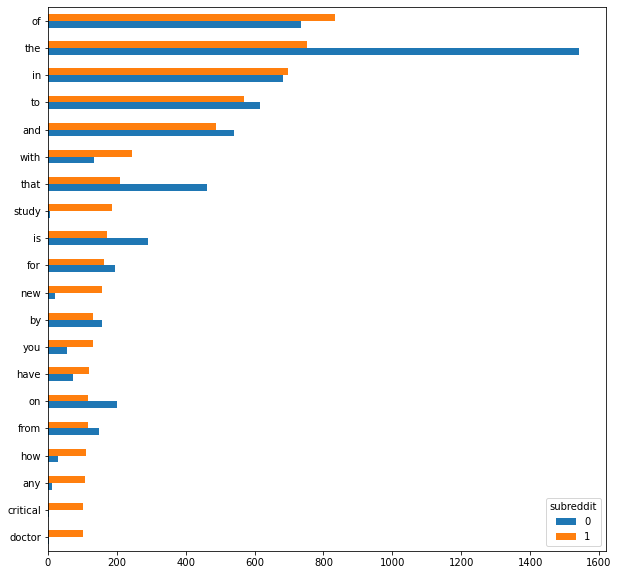

In [21]:
cvec1_train_df.groupby('subreddit').sum().T.sort_values(1, ascending=True).tail(20).plot.barh(figsize=(10,10));

In [22]:
cvec1_train_df['subreddit'].value_counts()

1    1125
0    1122
Name: subreddit, dtype: int64

In [23]:
cvec1_train_df.groupby('subreddit')['til'].mean()

subreddit
0    0.771836
1    0.000000
Name: til, dtype: float64

These graphs are pretty similar, but it makes sense since it the majority of the words are basic words like 'of', 'the', etc. The most obvious outlier is 'til' for r/todayilearn, which is the second most common word and occurs in 77% of the posts. Because 'til' appears in over 3/4 of the posts, I am adding it to the stop words list going forward.

# CountVectorizer with Stop Words

I am going to rerun the CountVectorizer with stop words being excluded. There are some common words that show up more in one subreddit over the other, 'the' being the biggest example. I want to see what the top words become without the stop words. The stop words will also include 'til'.

In [24]:
stopwords_amended = list(CountVectorizer(stop_words = 'english').get_stop_words())
stopwords_amended.append('til')
stopwords_amended

['whence',
 'without',
 'nine',
 'each',
 'becomes',
 'but',
 'thereupon',
 'her',
 'four',
 'in',
 'get',
 'them',
 'therefore',
 'onto',
 'own',
 'while',
 'three',
 'enough',
 'would',
 'de',
 'is',
 'side',
 'might',
 'nowhere',
 'do',
 'everything',
 'she',
 'couldnt',
 'and',
 'per',
 'behind',
 'never',
 'all',
 'everywhere',
 'besides',
 'towards',
 'nothing',
 'sixty',
 'interest',
 'these',
 'part',
 'we',
 'hereupon',
 'something',
 'when',
 'elsewhere',
 'by',
 'otherwise',
 'top',
 'myself',
 'on',
 'former',
 'hence',
 'made',
 'first',
 'has',
 'below',
 'one',
 'yet',
 'the',
 'over',
 'thick',
 'nor',
 'you',
 'to',
 'hers',
 'ever',
 'since',
 'thin',
 'whereby',
 'detail',
 'several',
 'although',
 'again',
 'thereafter',
 'than',
 'keep',
 'mostly',
 'am',
 'thereby',
 'during',
 'more',
 'him',
 'namely',
 'either',
 'could',
 'himself',
 'hereafter',
 'under',
 'whoever',
 'nevertheless',
 'also',
 'thus',
 'via',
 'wherein',
 'another',
 'was',
 'none',
 'whereve

In [25]:
cvec2 = CountVectorizer(stop_words=stopwords_amended)
cvec2.fit(X_train)
X_train_cvec2 = cvec2.transform(X_train)
X_test_cvec2 = cvec2.transform(X_test)

In [26]:
X_train_cvec2.shape

(2247, 9457)

In [27]:
cvec2_train_df = pd.DataFrame(X_train_cvec2.todense(), columns = cvec2.get_feature_names())

cvec2_train_df['subreddit'] = y_train.values

cvec2_train_df.head()

,000,001,02,021,03938,073,0900,096,098,0ver,...,मत,यद,रभ,वध,सक,ひきこもり,𝐋𝐞𝐚𝐤𝐞𝐝,𝐓𝐞𝐞𝐧𝐬,𝟏𝟕,subreddit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


There are 258 less columns, so that should hopefully change what the bar graphs show me.

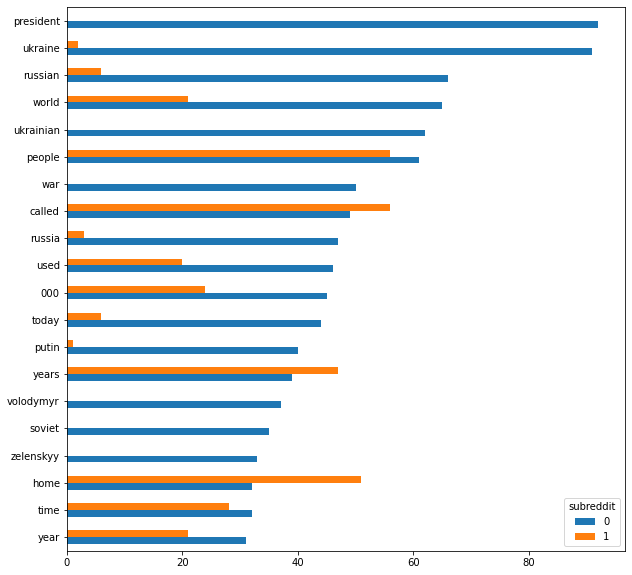

In [28]:
cvec2_train_df.groupby('subreddit').sum().T.sort_values(0, ascending=True).tail(20).plot.barh(figsize=(10,10));

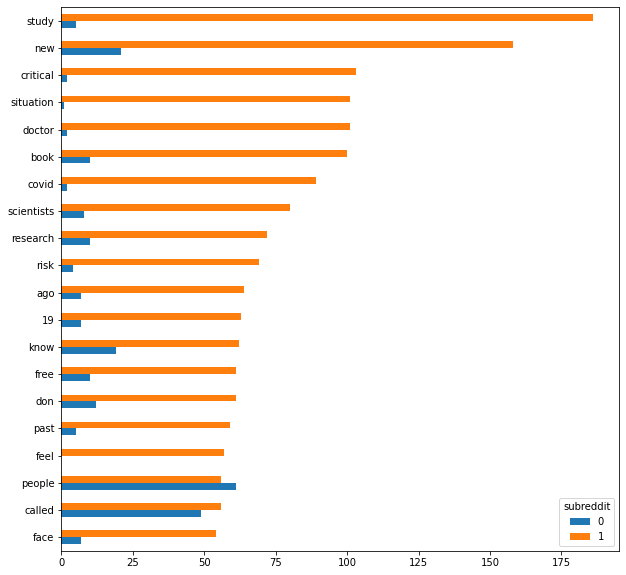

In [29]:
cvec2_train_df.groupby('subreddit').sum().T.sort_values(1, ascending=True).tail(20).plot.barh(figsize=(10,10));

Due to the time I took these posts, the Ukraine-Russia war affected the posts, but almost exclusively in r/todayilearned. I wasn't expecting that, but now that I see it, it makes sense since r/science is much more about sharing scientific articles while r/todayilearned can be about anything, including current events. Since this model is only being applied to the posts I collected, it is fine that words like "ukraine", "russia", "putin", etc. are used. If I were to try to use this model on completely new posts months down the road, it may need to be recalibrated.  

## Different Min_dfs

For this exploration, I am not going to include stop words since they show up so frequently and I am still going to omit 'til' as well. I am going to test a min_df of 3 and 5 individually to see how they compare to the original lists. 

In [30]:
cvec3 = CountVectorizer(stop_words=stopwords_amended, min_df=3)
cvec3.fit(X_train)
X_train_cvec3 = cvec3.transform(X_train)
X_test_cvec3 = cvec3.transform(X_test)

In [31]:
cvec3_train_df = pd.DataFrame(X_train_cvec3.todense(), columns = cvec3.get_feature_names())
cvec3_train_df['subreddit'] = y_train.values
cvec3_train_df.head()

,000,02,10,100,11,12,13,14,15,16,...,younger,youtube,za,zedong,zelensky,zelenskyy,zero,zone,zones,subreddit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


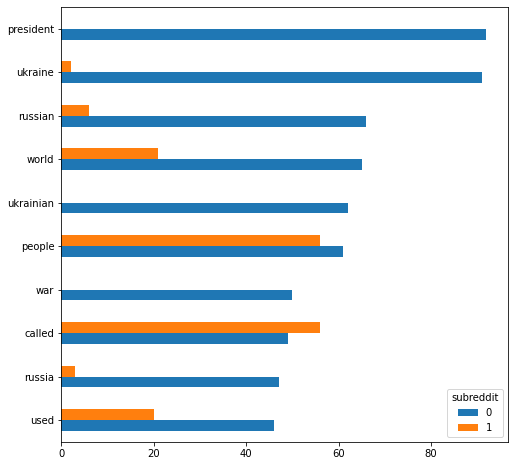

In [32]:
cvec3_train_df.groupby('subreddit').sum().T.sort_values(0, ascending=True).tail(10).plot.barh(figsize=(8,8));

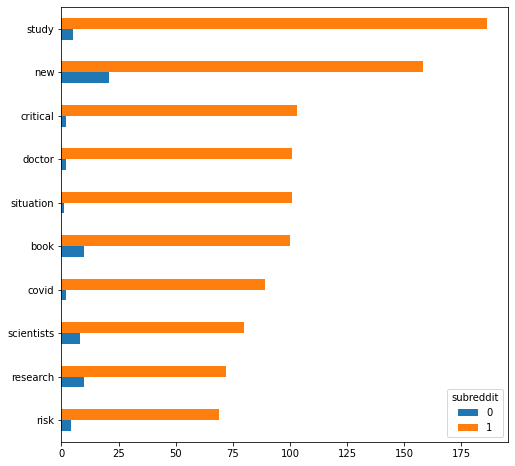

In [33]:
cvec3_train_df.groupby('subreddit').sum().T.sort_values(1, ascending=True).tail(10).plot.barh(figsize=(8,8));

In [34]:
cvec3_train_df.drop(columns='subreddit').shape[1]

2486

Logically, the top 10 for each doesn't change because those are obviously above the min_df and the graphs above reiterate that. What really changes is the number of features. It dropped by 6,970 features from 9,457 to 2,486.

In [35]:
cvec4 = CountVectorizer(stop_words=stopwords_amended, min_df=5)
cvec4.fit(X_train)
X_train_cvec4 = cvec4.transform(X_train)
X_test_cvec4 = cvec4.transform(X_test)

In [36]:
cvec4_train_df = pd.DataFrame(X_train_cvec4.todense(), columns = cvec4.get_feature_names())
cvec4_train_df['subreddit'] = y_train.values
cvec4_train_df.head()

,000,10,100,11,12,13,14,15,16,17,...,year,years,york,young,youtube,zelensky,zelenskyy,zero,zone,subreddit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [37]:
cvec4_train_df.drop(columns='subreddit').shape[1]

1239

While not as big a drop as from the original to min_df=3, there is still a 50.1% drop from 2,486 words to 1,239. I think this may be too few features for the models to effectively predict the subreddits, but I can also see it being useful because it gets down to what the subreddits most common words really are at the deepest level. I am going to give a wide range in 03_model to start to see how it goes. 

## Different Max_dfs

For this exploration, I am not going to include stop wordso'til' as well. I am going to test a max_df of .75 and .5 and see how they compare to the original lists and the min_df lists.

In [38]:
cvec5 = CountVectorizer(stop_words=stopwords_amended, max_df=.75)
cvec5.fit(X_train)
X_train_cvec5 = cvec5.transform(X_train)
X_test_cvec5 = cvec5.transform(X_test)

In [39]:
cvec5_train_df = pd.DataFrame(X_train_cvec5.todense(), columns = cvec5.get_feature_names())
cvec5_train_df['subreddit'] = y_train.values
cvec5_train_df.head()

,000,001,02,021,03938,073,0900,096,098,0ver,...,मत,यद,रभ,वध,सक,ひきこもり,𝐋𝐞𝐚𝐤𝐞𝐝,𝐓𝐞𝐞𝐧𝐬,𝟏𝟕,subreddit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [40]:
cvec5_train_df.drop(columns='subreddit').shape[1]

9457

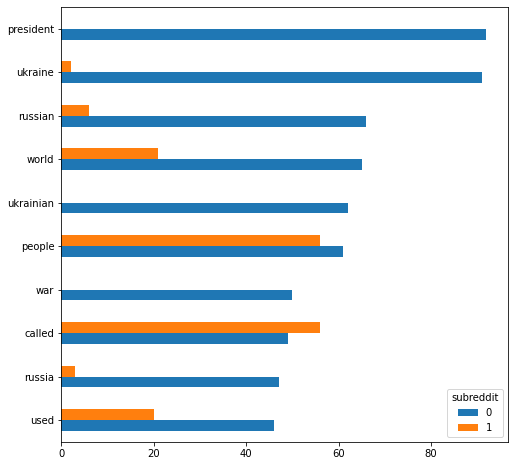

In [41]:
cvec5_train_df.groupby('subreddit').sum().T.sort_values(0, ascending=True).tail(10).plot.barh(figsize=(8,8));

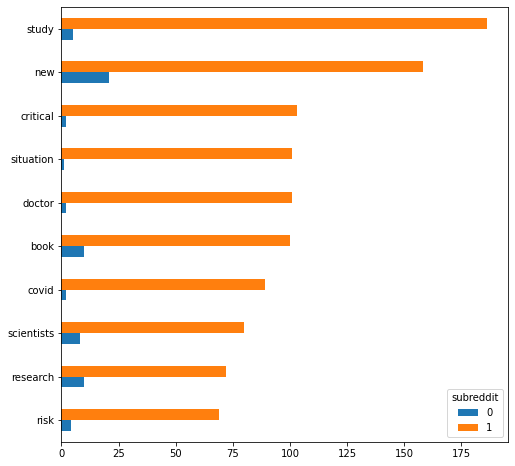

In [42]:
cvec5_train_df.groupby('subreddit').sum().T.sort_values(1, ascending=True).tail(10).plot.barh(figsize=(8,8));

Nothing changed, with the number of features staying at 9,457.

In [43]:
cvec6 = CountVectorizer(stop_words=stopwords_amended, max_df=.5)
cvec6.fit(X_train)
X_train_cvec6 = cvec6.transform(X_train)
X_test_cvec6 = cvec6.transform(X_test)

In [44]:
cvec6_train_df = pd.DataFrame(X_train_cvec6.todense(), columns = cvec6.get_feature_names())
cvec6_train_df['subreddit'] = y_train.values
cvec6_train_df.head()

,000,001,02,021,03938,073,0900,096,098,0ver,...,मत,यद,रभ,वध,सक,ひきこもり,𝐋𝐞𝐚𝐤𝐞𝐝,𝐓𝐞𝐞𝐧𝐬,𝟏𝟕,subreddit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [45]:
cvec6_train_df.drop(columns='subreddit').shape[1]

9457

Still nothing has changed. I expected something to move a bit, but it makes sense that nothing changed so far since the most any 1 word shows up in a document is around 180 times, which is around 12% of the documents. Since that's the case, I am going to test .05 just to see what will happen.

In [46]:
cvec7 = CountVectorizer(stop_words=stopwords_amended, max_df=.05)
cvec7.fit(X_train)
X_train_cvec7 = cvec7.transform(X_train)
X_test_cvec7 = cvec7.transform(X_test)

In [47]:
cvec7_train_df = pd.DataFrame(X_train_cvec7.todense(), columns = cvec7.get_feature_names())
cvec7_train_df['subreddit'] = y_train.values
cvec7_train_df.head()

,000,001,02,021,03938,073,0900,096,098,0ver,...,मत,यद,रभ,वध,सक,ひきこもり,𝐋𝐞𝐚𝐤𝐞𝐝,𝐓𝐞𝐞𝐧𝐬,𝟏𝟕,subreddit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [48]:
cvec7_train_df.drop(columns='subreddit').shape[1]

9455

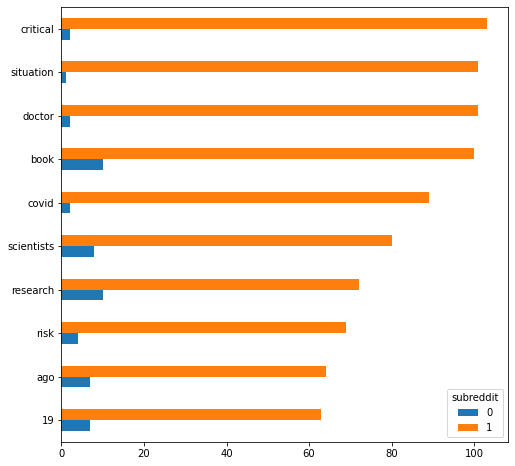

In [49]:
cvec7_train_df.groupby('subreddit').sum().T.sort_values(1, ascending=True).tail(10).plot.barh(figsize=(8,8));

Only 2 words dropped off: 'study' and 'new'. To me, this parameter is pretty much pointless for anymore EDA. I am going to leave it in the model because I will have the option to use stop words, which are far more common and more likely to be affected by max_df. 

## N-grams

N-grams can be a useful metric if done properly. I am going to do two versions, one with stop words and one without. I am also going to set the min_df to 2. Otherwise, there would be a lot of single n-grams that tell me nothing. 

In [50]:
cvec8 = CountVectorizer(stop_words=stopwords_amended, min_df=2, ngram_range=(2,2))
cvec8.fit(X_train)
X_train_cvec8 = cvec8.transform(X_train)
X_test_cvec8 = cvec8.transform(X_test)

In [51]:
cvec8_train_df = pd.DataFrame(X_train_cvec8.todense(), columns = cvec8.get_feature_names())
cvec8_train_df['subreddit'] = y_train.values
cvec8_train_df.head()

,000 800,000 couples,000 elephant,000 horses,000 specimens,000 times,000 year,000 years,10 000,10 20,...,zelenskyy president,zelenskyy starred,zelenskyy ukrainian,zelenskyy voice,zelenskyy wartime,zolgensma worlds,zombie dance,zone shifts,zones average,subreddit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


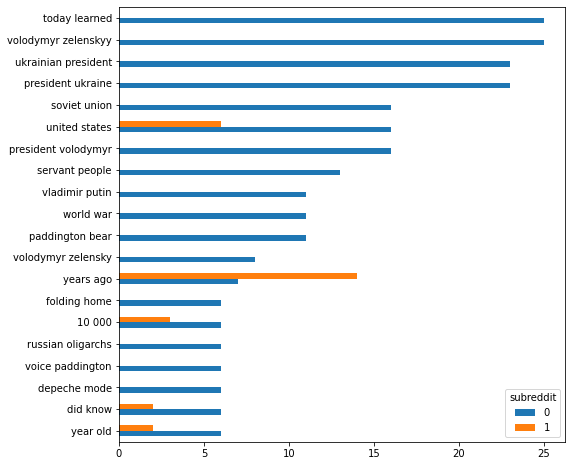

In [52]:
cvec8_train_df.groupby('subreddit').sum().T.sort_values(0, ascending=True).tail(20).plot.barh(figsize=(8,8));

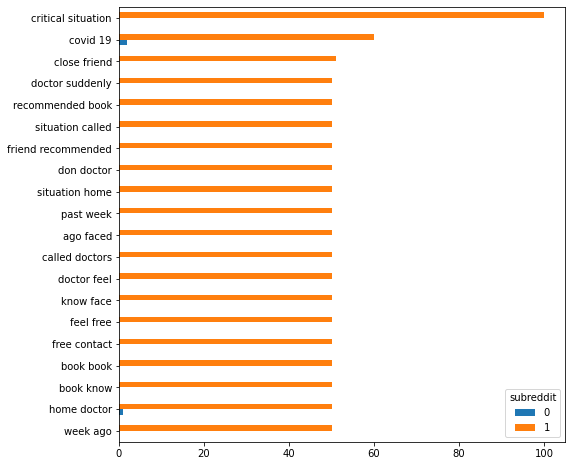

In [53]:
cvec8_train_df.groupby('subreddit').sum().T.sort_values(1, ascending=True).tail(20).plot.barh(figsize=(8,8));

Once again, because of world events, Ukraine and Russia based two-word combos are the vast majority of the top 20 list for r/todayilearned. On the other hand, r/science is much more diverse. It may be worth having in the pipeline.

In [54]:
cvec9 = CountVectorizer(stop_words=['til'], min_df=2, ngram_range=(2,2))
cvec9.fit(X_train)
X_train_cvec9 = cvec9.transform(X_train)
X_test_cvec9 = cvec9.transform(X_test)

In [55]:
cvec9_train_df = pd.DataFrame(X_train_cvec9.todense(), columns = cvec9.get_feature_names())
cvec9_train_df['subreddit'] = y_train.values
cvec9_train_df.head()

,000 couples,000 elephant,000 horses,000 of,000 specimens,000 times,000 years,10 000,10 20,10 million,...,zelenskyy played,zelenskyy starred,zelenskyy the,zelenskyy was,zelenskyy who,zolgensma worlds,zombie dance,zone shifts,zones than,subreddit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


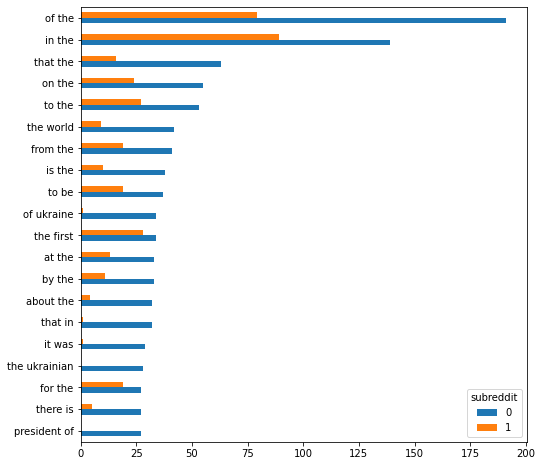

In [56]:
cvec9_train_df.groupby('subreddit').sum().T.sort_values(0, ascending=True).tail(20).plot.barh(figsize=(8,8));

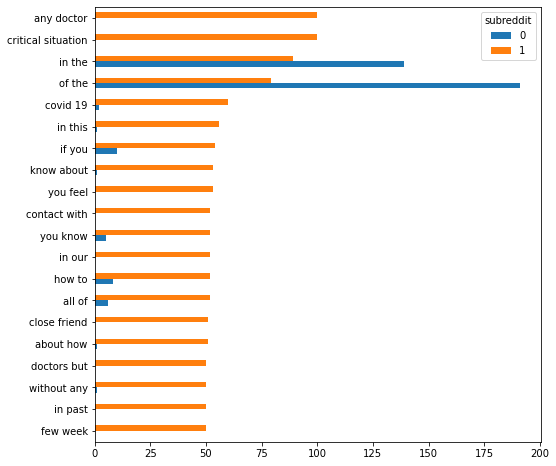

In [57]:
cvec9_train_df.groupby('subreddit').sum().T.sort_values(1, ascending=True).tail(20).plot.barh(figsize=(8,8));

I'm actually surprised the two most recent bar charts aren't more similar. I figured having the stop words included would make the lists similar, but they really aren't. 'In the' and 'of the' are the exception.

## Custom Tokenizer

This custom tokenizer will lemmatize and stem custom tokens for use in CountVectorizer. Since CountVectorizer does not do either of the aforementioned functions, this should produce new tokens and new top results. I will do one omitting stop words and one only ommiting 'til' to see the difference between the two. 

In [58]:
# From the lesson-nlp-ii starter-code notebook.
tokenizer = CountVectorizer().build_tokenizer()

def custom_tokenizer(text):
    lemmatizer = WordNetLemmatizer()
    p_stemmer = PorterStemmer()
    tokens = tokenizer(text)
    tokens_lem = [lemmatizer.lemmatize(token) for token in tokens]
    tokens_stem = [p_stemmer.stem(token) for token in tokens_lem]
    return tokens_stem

In [59]:
cvec10 = CountVectorizer(stop_words=['til'], tokenizer=custom_tokenizer, token_pattern=None)
cvec10.fit(X_train)
X_train_cvec10 = cvec10.transform(X_train)
X_test_cvec10 = cvec10.transform(X_test)
# Included token_pattern=None because it throws a warning otherwise. 

In [60]:
cvec10_train_df = pd.DataFrame(X_train_cvec10.todense(), columns = cvec10.get_feature_names())
cvec10_train_df['subreddit'] = y_train.values
cvec10_train_df.head()

,000,001,02,021,03938,073,0900,096,098,0ver,...,मत,यद,रभ,वध,सक,ひきこもり,𝐋𝐞𝐚𝐤𝐞𝐝,𝐓𝐞𝐞𝐧𝐬,𝟏𝟕,subreddit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


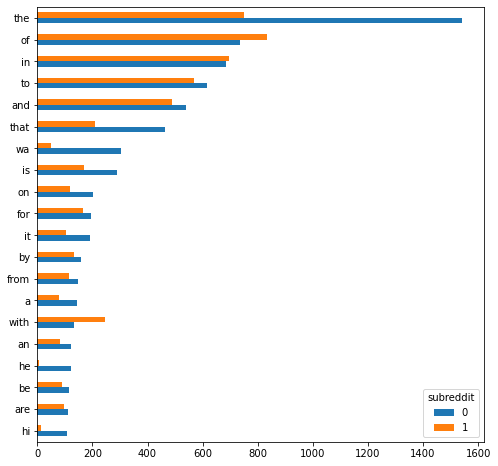

In [61]:
cvec10_train_df.groupby('subreddit').sum().T.sort_values(0, ascending=True).tail(20).plot.barh(figsize=(8,8));

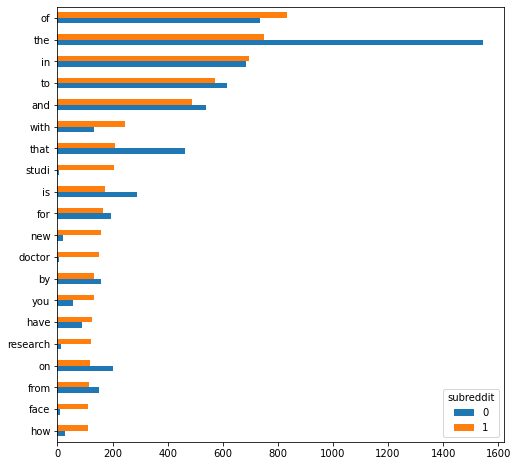

In [62]:
cvec10_train_df.groupby('subreddit').sum().T.sort_values(1, ascending=True).tail(20).plot.barh(figsize=(8,8));

I can't tell much from these charts, which is to be expected since the stop words were included.

In [63]:
cvec11 = CountVectorizer(stop_words=stopwords_amended, tokenizer=custom_tokenizer, token_pattern=None)
cvec11.fit(X_train)
X_train_cvec11 = cvec11.transform(X_train)
X_test_cvec11 = cvec11.transform(X_test)


C:\Users\tpric\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'le', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'u', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_wor

In [64]:
cvec11_train_df = pd.DataFrame(X_train_cvec11.todense(), columns = cvec11.get_feature_names())
cvec11_train_df['subreddit'] = y_train.values
cvec11_train_df.head()

,000,001,02,021,03938,073,0900,096,098,0ver,...,मत,यद,रभ,वध,सक,ひきこもり,𝐋𝐞𝐚𝐤𝐞𝐝,𝐓𝐞𝐞𝐧𝐬,𝟏𝟕,subreddit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


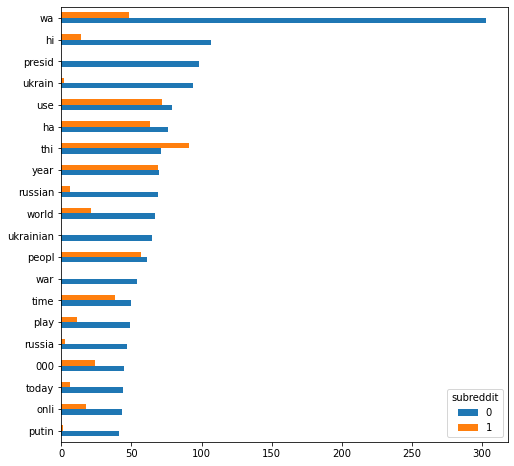

In [65]:
cvec11_train_df.groupby('subreddit').sum().T.sort_values(0, ascending=True).tail(20).plot.barh(figsize=(8,8));

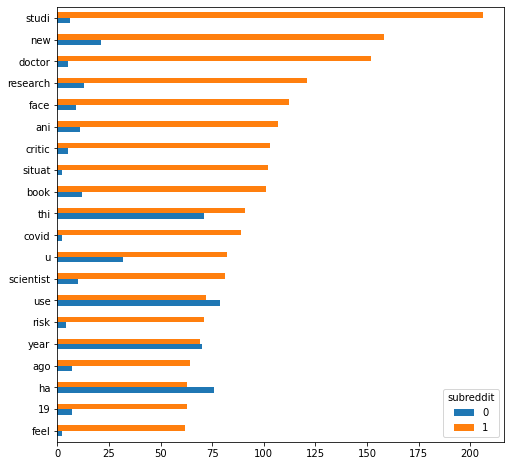

In [66]:
cvec11_train_df.groupby('subreddit').sum().T.sort_values(1, ascending=True).tail(20).plot.barh(figsize=(8,8));

I don't think this helped at all. The words are pretty similar to the ones before, and the stop words are not working correctly due to the custom tokenizer. I don't think I will use a custom tokenizer for my model because it is not telling me anything new that isn't already shown with the standard CountVectorizer.

## Token Pattern


In this section I am going to try a different token pattern that I worked out in regex101.com. It's not too different, but I want to see the effect it has on the word counts and top words. 

In [67]:
cvec12 = CountVectorizer(stop_words=stopwords_amended, token_pattern='\w+[[:punct:]]\d+|\w{2,}')
cvec12.fit(X_train)
X_train_cvec12 = cvec12.transform(X_train)
X_test_cvec12 = cvec12.transform(X_test)

C:\Users\tpric\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:342: FutureWarning: Possible nested set at position 4
  token_pattern = re.compile(self.token_pattern)


In [68]:
cvec12_train_df = pd.DataFrame(X_train_cvec12.todense(), columns = cvec12.get_feature_names())
cvec12_train_df['subreddit'] = y_train.values
cvec12_train_df.head()

,000,001,02,021,03938,073,0900,096,098,0ver,...,मत,यद,रभ,वध,सक,ひきこもり,𝐋𝐞𝐚𝐤𝐞𝐝,𝐓𝐞𝐞𝐧𝐬,𝟏𝟕,subreddit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


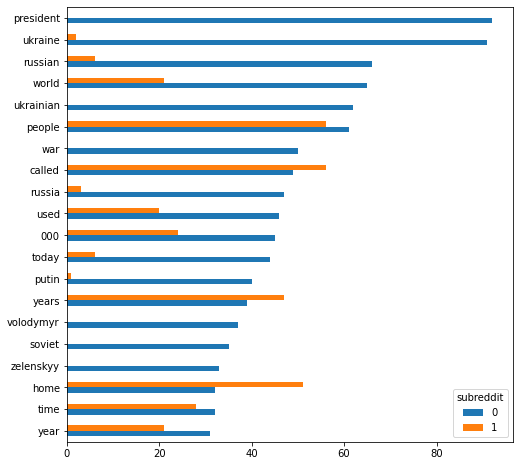

In [69]:
cvec12_train_df.groupby('subreddit').sum().T.sort_values(0, ascending=True).tail(20).plot.barh(figsize=(8,8));

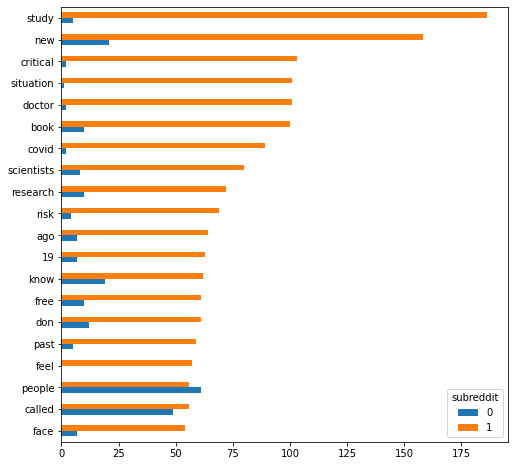

In [70]:
cvec12_train_df.groupby('subreddit').sum().T.sort_values(1, ascending=True).tail(20).plot.barh(figsize=(8,8));

I thought this pattern might combine some words together like "Covid-19", but that does not seem to be the case. There are the same number of rows as before, so this token is not going to give anything new. I tried a couple of other token patterns on regex101.com, but none of them had good results. As such, I will be omitting this parameter in my models. 

## Word Count

For this section, I am going to look at the word count for each post and see if there is a difference between the two subreddits. I am keeping it simple by splitting on the space for the word count, so numbers and the like will be counted as words. For the purposes of this project, including numbers in the word count is ok.

In [71]:
def word_count(all_text):
    return len(all_text.split())

In [72]:
df['word_count'] = df['all_text'].map(word_count)

In [73]:
df.head()

,title,selftext,subreddit,created_utc,all_text,word_count
0,Germany Aims To Get 100% of Energy From Renewable Sources By 2035,,1,1646141490,Germany Aims To Get 100% of Energy From Renewable Sources By 2035,12
1,Ambiental Dedetização - Dedetizadora e controle de Pragas,,1,1646140604,Ambiental Dedetização - Dedetizadora e controle de Pragas,8
2,"Alcohol use by parents of young children was related to how many bars and restaurants were near where they shopped, where they worked and where their children went to school, a new study finds.",,1,1646138910,"Alcohol use by parents of young children was related to how many bars and restaurants were near where they shopped, where they worked and where their children went to school, a new study finds.",34
3,Neighbourhoods Play A Role In Health Of Adults. Results confirm previous findings but now also show a clear link between living environments and physical and mental health. He believes they should help inform city planning policy and decision-making.,,1,1646132676,Neighbourhoods Play A Role In Health Of Adults. Results confirm previous findings but now also show a clear link between living environments and physical and mental health. He believes they should help inform city planning policy and decision-making.,38
4,Ultrasound scan can diagnose prostate cancer. The ultrasound scans missed only 4.3 per cent more clinically important prostate cancer cases – cancer that should be treated rather than monitored – compared to magnetic resonance imaging (MRI) scans currently used to detect prostate cancer,,1,1646132446,Ultrasound scan can diagnose prostate cancer. The ultrasound scans missed only 4.3 per cent more clinically important prostate cancer cases – cancer that should be treated rather than monitored – compared to magnetic resonance imaging (MRI) scans currently used to detect prostate cancer,43


In [74]:
sci_df = df[df['subreddit'] == 1]

In [75]:
til_df = df[df['subreddit'] == 0]

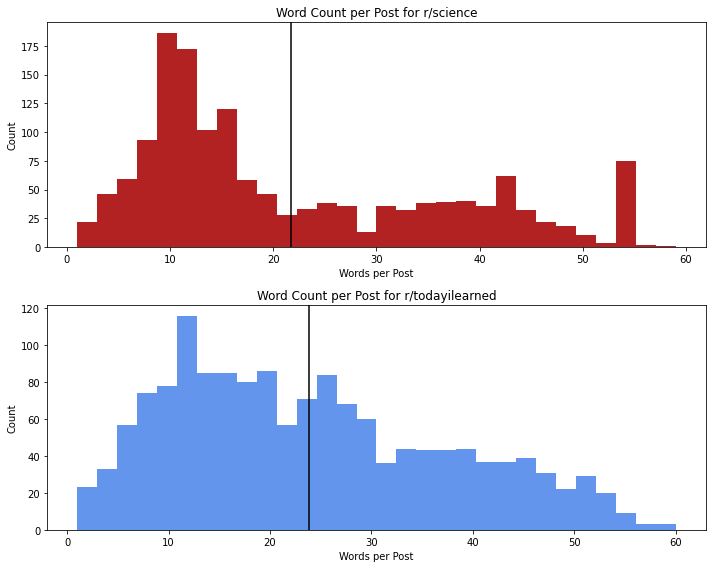

In [76]:
plt.figure(figsize=(10,8))

ax1 = plt.subplot(2,1,1)
ax1.hist(sci_df['word_count'], bins=30, color='firebrick')
ax1.axvline(sci_df['word_count'].mean(), color='k')
ax1.set_title('Word Count per Post for r/science')
ax1.set_xlabel('Words per Post')
ax1.set_ylabel('Count')

ax2 = plt.subplot(2,1,2)
ax2.hist(til_df['word_count'], bins=30, color='cornflowerblue')
ax2.axvline(til_df['word_count'].mean(), color='k')
ax2.set_title('Word Count per Post for r/todayilearned')
ax2.set_xlabel('Words per Post')
ax2.set_ylabel('Count')

plt.tight_layout();

In [77]:
print('r/science average: '+str(sci_df['word_count'].mean()))
print('r/todayilearned average: '+str(til_df['word_count'].mean()))

r/science average: 21.742
r/todayilearned average: 23.84569138276553


Both averages are just over 20, but r/science is more centered around 10 while r/todayilearned is more evenly spreadout. This could be useful for the model, so I'm going to save the spreadsheet and use it for modeling in notebook 03.

In [78]:
df.to_csv('../data/cleaned/prepped_posts_with_count.csv', index=False)

## Sentiment Analysis


For this section, I am looking at the compound sentiment score for each post. I don't know if anything can be learned from this, but I theorize that the r/science posts will be mostly neutral while the r/todayilearned will be a little more extreme due to a decent chunk of them talking about the current war in Ukraine. 

In [79]:
# From lesson-nlp-i starter-code notebook.
sia = SentimentIntensityAnalyzer()

In [80]:
def extract_sentiment(post):
    scores = sia.polarity_scores(post)
    return scores['compound']

In [81]:
df['sentiment'] = df['all_text'].map(extract_sentiment)

In [82]:
df

,title,selftext,subreddit,created_utc,all_text,word_count,sentiment
0,Germany Aims To Get 100% of Energy From Renewable Sources By 2035,,1,1646141490,Germany Aims To Get 100% of Energy From Renewable Sources By 2035,12,0.2732
1,Ambiental Dedetização - Dedetizadora e controle de Pragas,,1,1646140604,Ambiental Dedetização - Dedetizadora e controle de Pragas,8,0.0000
2,"Alcohol use by parents of young children was related to how many bars and restaurants were near where they shopped, where they worked and where their children went to school, a new study finds.",,1,1646138910,"Alcohol use by parents of young children was related to how many bars and restaurants were near where they shopped, where they worked and where their children went to school, a new study finds.",34,0.0000
3,Neighbourhoods Play A Role In Health Of Adults. Results confirm previous findings but now also show a clear link between living environments and physical and mental health. He believes they should help inform city planning policy and decision-making.,,1,1646132676,Neighbourhoods Play A Role In Health Of Adults. Results confirm previous findings but now also show a clear link between living environments and physical and mental health. He believes they should help inform city planning policy and decision-making.,38,0.8248
4,Ultrasound scan can diagnose prostate cancer. The ultrasound scans missed only 4.3 per cent more clinically important prostate cancer cases – cancer that should be treated rather than monitored – compared to magnetic resonance imaging (MRI) scans currently used to detect prostate cancer,,1,1646132446,Ultrasound scan can diagnose prostate cancer. The ultrasound scans missed only 4.3 per cent more clinically important prostate cancer cases – cancer that should be treated rather than monitored – compared to magnetic resonance imaging (MRI) scans currently used to detect prostate cancer,43,-0.9624
...,...,...,...,...,...,...,...
2992,TIL Pandora didn't have a box,,0,1645530046,TIL Pandora didn't have a box,6,0.0000
2993,Ms Excel Complete course for beginners to Advance level|| step by step|| Part 2,,0,1645529820,Ms Excel Complete course for beginners to Advance level|| step by step|| Part 2,14,0.4588
2994,"TIL If measured from the ocean floor, Mount Teide at it's height of 7500 m is the third-highest volcano in the world.",,0,1645529785,"TIL If measured from the ocean floor, Mount Teide at it's height of 7500 m is the third-highest volcano in the world.",22,0.0000
2995,Nehmen Sie an einem Supermarkt-Gutschein teil! kostenlos,,0,1645528261,Nehmen Sie an einem Supermarkt-Gutschein teil! kostenlos,7,0.0000


Looking at the posts above, I don't think there will be any pattern. I don't get why the 5th post is very negative while the 4th post is super positive.

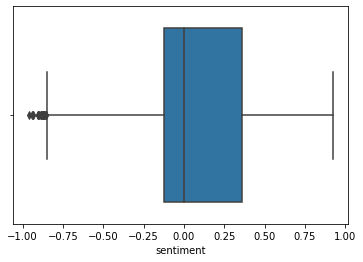

In [83]:
sns.boxplot(x = df[df['subreddit']==1]['sentiment']);

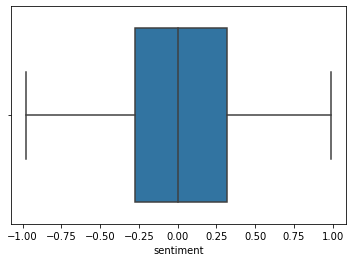

In [84]:
sns.boxplot(x = df[df['subreddit']==0]['sentiment']);

When looking at the boxplots above and the sentiment scores shown above, I don't think this would be useful in the models. The median for both is 0 and they have roughly the same quartiles, though r/science is skewed a little more positive but also shows outliers all the way to -1. I am not going to use this in my models.

# Next Steps


Now that I have completed my EDA, I am going to transition over to the 03_Modeling notebook. There I will be running a K Nearest Neighbors model and a Logistic Regression model to see which one is superior. I will be using all of the features I chose in this notebook there, but I may use wider ranges since EDA and modeling might behave differently. 